# INFO
This page pulls the latest Johns Hopkins data for COVID-19 and performs some basic analysis.

Author: Greg Schwimer

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import os

# Get the Johns Hopkins Time Series data
raw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
rawd = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')

In [2]:
# tenderize the data a little bit

# only want US proper
data = raw.loc[raw['iso2'] == 'US']

# timeseries only
data = data.iloc[:, 11:]

# summarize the data
summary = data.sum()

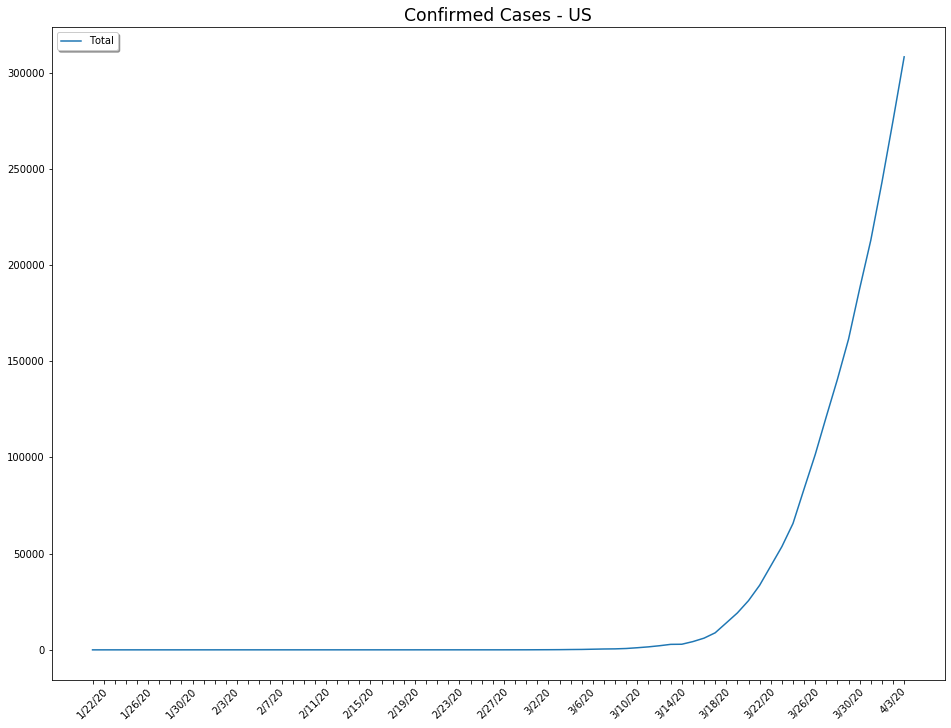

In [3]:
# Confirmed cases

# limits on the data - helps get rid of uncertainty in early data
# counts = summary['3/20/20':]
counts = summary

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
ax.plot(counts)
every_nth = 4
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.xticks(rotation=45)
plt.legend(('Total',), shadow=True, loc='upper left')
plt.title('Confirmed Cases - US', fontsize='xx-large')
plt.show()

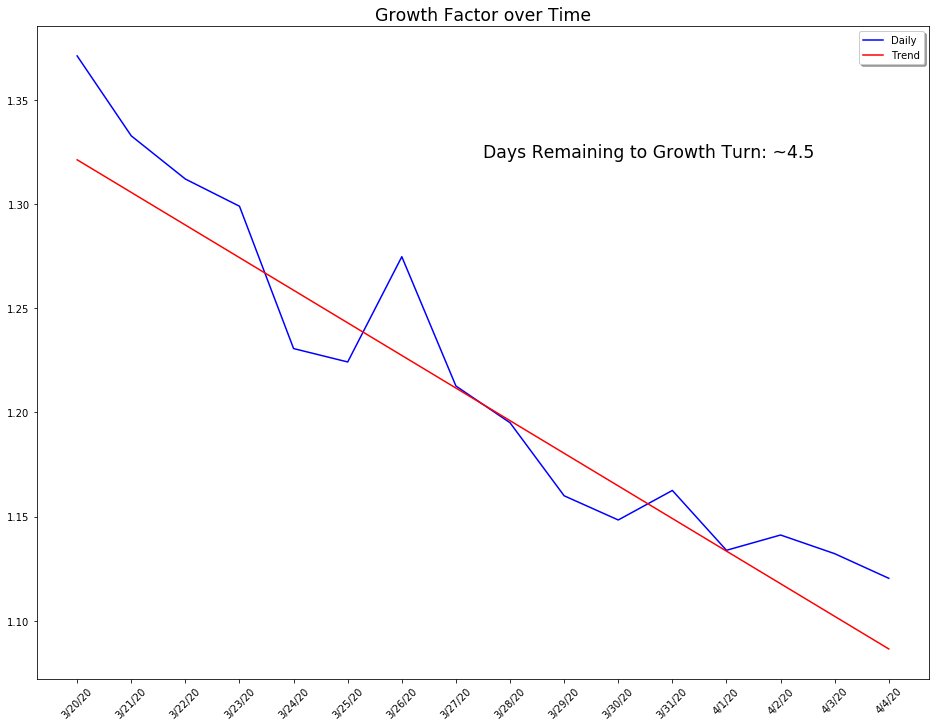

In [4]:
# Growth Factor Analysis

# Growth is calculated as (day / (day - 1))
growth = summary / summary.shift()
growth = growth.fillna(growth.median()) # get rid of NaNs
growth = growth['3/20/20':] # limit to drop out early data w/ lots of uncertainty

# linreg to establish the growth trend - DEPRECATED
lr = stats.linregress(range(growth.shape[0]), growth.values)
linreg = pd.Series([(lr[1] + lr[0] * x) for x in range(growth.shape[0])],
                   index=growth.index)

# theil slope to establish the growth trend
ts = stats.theilslopes(growth.values, range(growth.shape[0]), 0.95)
tslopes = pd.Series([(ts[1] + ts[0] * x) for x in range(growth.shape[0])], 
                    index=growth.index)
tslopes_lower = pd.Series([(ts[1] + ts[2] * x) for x in range(growth.shape[0])], 
                          index=growth.index)
tslopes_upper = pd.Series([(ts[1] + ts[3] * x) for x in range(growth.shape[0])], 
                          index=growth.index)

# How long until growth factor 1? 
days_to_one = (1 - ts[1]) / ts[0]
days_remaining = days_to_one - growth.shape[0]


# plot the growth factor and trend

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
ax.plot(growth, 'b-')
# ax.plot(linreg, 'g-')
ax.plot(tslopes, 'r-')
# ax.plot(tslopes_upper, 'r--')
# ax.plot(tslopes_lower, 'r--')
ax.text(.5, .8, 'Days Remaining to Growth Turn: ~{:.2}'.format(days_remaining), 
        fontsize='xx-large', transform=ax.transAxes)
plt.xticks(rotation=45)
plt.legend(('Daily', 'Trend'), shadow=True, loc='upper right')
plt.title('Growth Factor over Time', fontsize='xx-large')
plt.show()